### The dataset can be downloaded from [here](https://github.com/ardamavi/Sign-Language-Digits-Dataset) .
Details of datasets:
Image size: 100 x 100 pixels  
- Color space: RGB  
- Number of classes: 10 (Digits: 0-9)  
- Number of participant students: 218  
- Number of samples per student: 10


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
# from tensorflow.keras.applications import imagenet_utils
from keras.applications.mobilenet import preprocess_input, decode_predictions


from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Organize data into 'train', 'test' & 'valid' directories

In [3]:
os.chdir('/home/satyam/Desktop/GIT/helper-notebooks-data-science/Sign-Language-Digits/dataset')

if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in 0:
        
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
            
os.chdir('../../')

In [4]:
train_path = '/home/satyam/Desktop/GIT/helper-notebooks-data-science/Sign-Language-Digits/dataset/train'
valid_path = '/home/satyam/Desktop/GIT/helper-notebooks-data-science/Sign-Language-Digits/dataset/valid'
test_path  = '/home/satyam/Desktop/GIT/helper-notebooks-data-science/Sign-Language-Digits/dataset/test'

### Preprocessing the Data

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10)

test_batches  = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


### Building our Model as per requirements

In [6]:
 mobile = tf.keras.applications.mobilenet.MobileNet()

W0629 22:29:25.363281 140335914788672 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

### Functional (model) API keras

In [8]:
x = mobile.layers[-6].output
output = Dense(units=10, activation='softmax')(x)

In [9]:
# taking inputs from original 'MobileNet' module -> 'mobile.input'

model = Model(inputs=mobile.input, outputs=output)

In [10]:
# total 88 layers in 'MobileNet' model, out of which we freeze all the layers except the last 23 layers

for layer in model.layers[:-23]:
    layer.trainable = False
    

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

# train for ~40 to 50 epochs on battery plugged-in

Epoch 1/10
172/172 - 72s - loss: 0.8257 - acc: 0.7453 - val_loss: 1.0772 - val_acc: 0.6567
Epoch 2/10
172/172 - 71s - loss: 0.1865 - acc: 0.9579 - val_loss: 0.7388 - val_acc: 0.7900
Epoch 3/10
172/172 - 71s - loss: 0.1000 - acc: 0.9854 - val_loss: 0.6584 - val_acc: 0.7867
Epoch 4/10
172/172 - 72s - loss: 0.0609 - acc: 0.9959 - val_loss: 0.5646 - val_acc: 0.8133
Epoch 5/10
172/172 - 75s - loss: 0.0450 - acc: 0.9959 - val_loss: 0.4009 - val_acc: 0.9300
Epoch 6/10
172/172 - 75s - loss: 0.0326 - acc: 0.9971 - val_loss: 0.4444 - val_acc: 0.8567
Epoch 7/10
172/172 - 76s - loss: 0.0264 - acc: 0.9977 - val_loss: 0.3910 - val_acc: 0.8967
Epoch 8/10
172/172 - 76s - loss: 0.0188 - acc: 1.0000 - val_loss: 0.4180 - val_acc: 0.8767
Epoch 9/10
172/172 - 75s - loss: 0.0116 - acc: 1.0000 - val_loss: 0.3699 - val_acc: 0.9033
Epoch 10/10
172/172 - 73s - loss: 0.0163 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.7833


### Predictions

In [14]:
test_labels = test_batches.classes

In [15]:
predictions = model.predict(x=test_batches, verbose=1)

5/5 [==============================] - 2s 319ms/step


In [20]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

### Plot results to CONFUSION MATRIX

In [21]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [22]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion Matrix', 
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    else:
        print("Confusion matrix w/o normalization")
        
    print(cm)
    
    thres = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i, j]>thres else "black")
        
    plt.tight_layout()
    plt.ylabel('TRUE LABEL')
    plt.xlabel('PREDICTED LABEL')

Confusion matrix w/o normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 1 0 0 0]
 [0 1 0 0 0 4 0 0 0 0]
 [0 0 0 0 4 1 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 1 0 0 0 0 0 0 4 0]
 [0 5 0 0 0 0 0 0 0 0]]


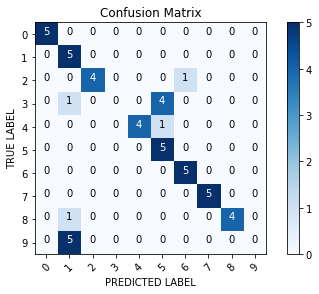

In [25]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')